In [3]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import os
from tqdm import tqdm
import cv2

Mounted at /content/gdrive


In [ ]:
!unzip -uq "/content/gdrive/MyDrive/train.zip" -d "/content/gdrive/MyDrive/train"

In [ ]:
!unzip -uq "/content/gdrive/MyDrive/test.zip" -d "/content/gdrive/MyDrive/test"

In [4]:
x_train = []
x_test = []
y_train = []

label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

dirs = os.listdir("/content/gdrive/MyDrive/train")
for k in tqdm(range(len(dirs))):
    files = os.listdir("/content/gdrive/MyDrive/train/{}".format(dirs[k]))
    for f in range(len(files)):
        img = cv2.imread('/content/gdrive/MyDrive/train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(12)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (256, 256)))
        y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 12/12 [25:25<00:00, 127.08s/it]


(4750, 256, 256, 3)
(4750, 12)


In [5]:
x_train = x_train/255.0

In [6]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [7]:
y_train.sum(axis=0)

array([263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385],
      dtype=uint64)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1,test_size=0.3, random_state=1)
for train_index, test_index in sss.split(x_train, y_train):
    X_train, X_val = x_train[train_index], x_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

In [9]:
y_train.sum(axis=0)

array([184, 273, 201, 428, 155, 332, 458, 155, 361, 162, 347, 269],
      dtype=uint64)

In [10]:
y_val.sum(axis=0)

array([ 79, 117,  86, 183,  66, 143, 196,  66, 155,  69, 149, 116],
      dtype=uint64)

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape = (256, 256, 3), include_top = False,weights = 'imagenet',pooling='avg')
vgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [36]:
for layer in vgg.layers:
    layer.trainable = False

In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential

x = layers.Flatten()(vgg.output)

x = layers.Dense(128, activation='relu')(x)

x = layers.Dense(12, activation='softmax')(x)

model = tf.keras.models.Model(vgg.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [51]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
mc = ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [52]:
vgghist = model.fit(X_train,y_train, validation_data = (X_val,y_val), batch_size=64, epochs = 20,callbacks=[mc])

Epoch 1/20
52/52 [==============================] - 92s 2s/step - loss: 2.3198 - accuracy: 0.2223 - val_loss: 2.1497 - val_accuracy: 0.2484
Epoch 2/20
52/52 [==============================] - 24s 458ms/step - loss: 1.9161 - accuracy: 0.3371 - val_loss: 1.8662 - val_accuracy: 0.3467
Epoch 3/20
52/52 [==============================] - 24s 469ms/step - loss: 1.7558 - accuracy: 0.3877 - val_loss: 1.8849 - val_accuracy: 0.3446
Epoch 4/20
52/52 [==============================] - 25s 485ms/step - loss: 1.6433 - accuracy: 0.4226 - val_loss: 1.6995 - val_accuracy: 0.3825
Epoch 5/20
52/52 [==============================] - 26s 497ms/step - loss: 1.5482 - accuracy: 0.4454 - val_loss: 1.6125 - val_accuracy: 0.4267
Epoch 6/20
52/52 [==============================] - 26s 497ms/step - loss: 1.4755 - accuracy: 0.4743 - val_loss: 1.4371 - val_accuracy: 0.4800
Epoch 7/20
52/52 [==============================] - 26s 504ms/step - loss: 1.4028 - accuracy: 0.5035 - val_loss: 1.3317 - val_accuracy: 0.5319
Ep

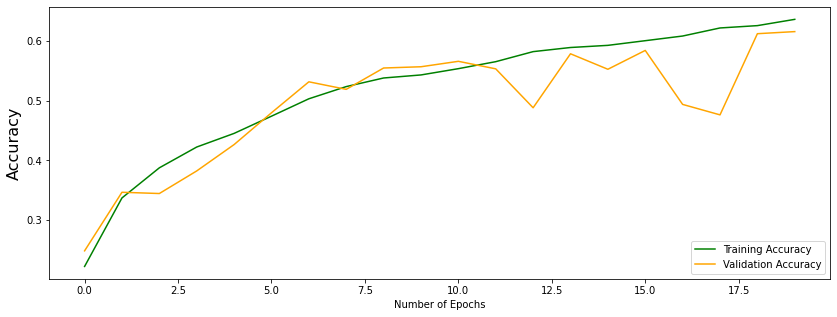

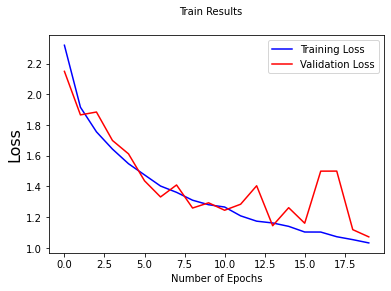

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vgghist.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(vgghist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(vgghist.history['loss'], color='b', label='Training Loss')
plt.plot(vgghist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [59]:
vgg_model = load_model('best_model_vgg16.h5')

In [61]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
y_pred = vgg_model.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1) 

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))

[[ 34   1   0   0  12   6  22   0   4   0   0   0]
 [  0  86   7   0   0   6   0   1   3   0  13   1]
 [  0   9  57   1   0   2   1   1  10   0   5   0]
 [  0   1   1 124   1   2   3   0  27   1  23   0]
 [  0   0   1   1  31   7  14   1   9   0   0   2]
 [  1   9  10   3   1  80  19   1   8   0   3   8]
 [ 19   0   2   3  11  15 114   0  29   0   3   0]
 [  0   8   3   0   1   2   0  16  15   0   0  21]
 [  1   2   1  13   0   5   6   0 121   0   6   0]
 [  0   2   1   9   0   1   0   0  25   6  25   0]
 [  0   7   4   2   0   2   0   0   3   0 131   0]
 [  1   2   1   0   1  23   2   1   6   1   0  78]]
              precision    recall  f1-score   support

           0       0.61      0.43      0.50        79
           1       0.68      0.74      0.70       117
           2       0.65      0.66      0.66        86
           3       0.79      0.68      0.73       183
           4       0.53      0.47      0.50        66
           5       0.53      0.56      0.54       143
        

In [73]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet',pooling='avg')
for layer in inception.layers[:200]:
    layer.trainable = False

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_98[0][0]     
_______________________________________________________________________________________

In [76]:
x = layers.Flatten()(inception.output)

x = layers.Dropout(0.5)(x)

x = layers.Dense(12, activation='softmax')(x)

model_inc = tf.keras.models.Model(inception.input, x)

model_inc.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [77]:
mc_inc = ModelCheckpoint('best_model_inception.h5', monitor='val_accuracy', mode='max', save_best_only=True)
inc_hist = model_inc.fit(X_train,y_train, validation_data = (X_val,y_val), batch_size=64, epochs = 15,callbacks=[mc_inc])

Epoch 1/15
52/52 [==============================] - 25s 384ms/step - loss: 1.9923 - accuracy: 0.3585 - val_loss: 1.3688 - val_accuracy: 0.6744
Epoch 2/15
52/52 [==============================] - 19s 369ms/step - loss: 1.1279 - accuracy: 0.7161 - val_loss: 0.9170 - val_accuracy: 0.7628
Epoch 3/15
52/52 [==============================] - 19s 370ms/step - loss: 0.7149 - accuracy: 0.8394 - val_loss: 0.6957 - val_accuracy: 0.8000
Epoch 4/15
52/52 [==============================] - 19s 374ms/step - loss: 0.4983 - accuracy: 0.8872 - val_loss: 0.5707 - val_accuracy: 0.8295
Epoch 5/15
52/52 [==============================] - 19s 376ms/step - loss: 0.3494 - accuracy: 0.9209 - val_loss: 0.5005 - val_accuracy: 0.8491
Epoch 6/15
52/52 [==============================] - 20s 395ms/step - loss: 0.2710 - accuracy: 0.9380 - val_loss: 0.4487 - val_accuracy: 0.8618
Epoch 7/15
52/52 [==============================] - 19s 374ms/step - loss: 0.2042 - accuracy: 0.9552 - val_loss: 0.4182 - val_accuracy: 0.8709

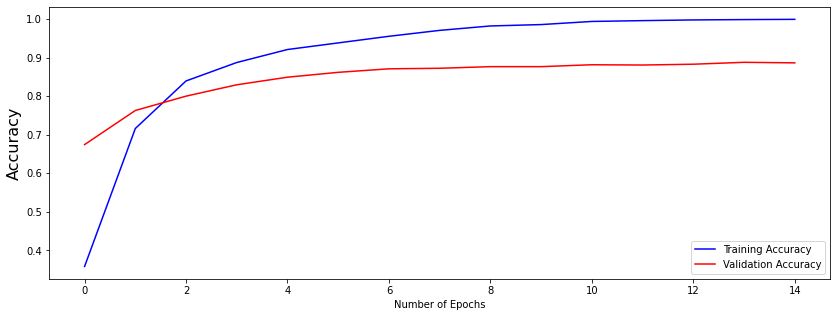

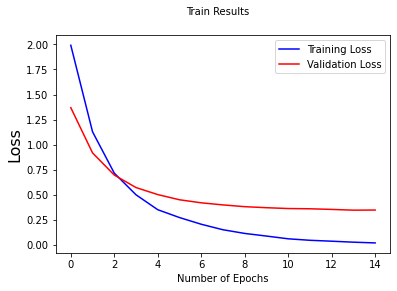

In [78]:
plt.figure(figsize=(14,5))

plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(inc_hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(inc_hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(inc_hist.history['loss'], color='b', label='Training Loss')
plt.plot(inc_hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [79]:
inception_model = load_model('best_model_inception.h5')

In [81]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
y_pred = inception_model.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1) 

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))

[[ 36   0   0   0   4   1  37   1   0   0   0   0]
 [  0 115   1   0   0   1   0   0   0   0   0   0]
 [  0   3  78   0   0   1   0   1   0   1   1   1]
 [  1   0   0 167   1   4   1   0   6   2   1   0]
 [  2   0   0   0  55   1   2   3   0   1   0   2]
 [  1   3   0   0   2 131   3   1   1   0   0   1]
 [ 10   0   0   0   2   1 182   0   1   0   0   0]
 [  0   0   0   0   0   0   0  65   0   0   0   1]
 [  1   0   0   4   1   0   6   0 141   2   0   0]
 [  0   0   0   2   0   0   0   0  14  49   4   0]
 [  0   0   0   1   0   0   1   0   0   1 146   0]
 [  0   1   0   2   0  10   0   1   2   0   0 100]]
              precision    recall  f1-score   support

           0       0.71      0.46      0.55        79
           1       0.94      0.98      0.96       117
           2       0.99      0.91      0.95        86
           3       0.95      0.91      0.93       183
           4       0.85      0.83      0.84        66
           5       0.87      0.92      0.89       143
        

In [91]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(input_shape=(256, 256,3), include_top=False, weights="imagenet",pooling='avg')
resnet.summary()
for layer in resnet.layers[:80]:
    layer.trainable = False

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [96]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
x = layers.Flatten()(resnet.output)

x = layers.Dense(12, activation='softmax')(x)

model = tf.keras.models.Model(resnet.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [98]:
mc_res = ModelCheckpoint('best_model_resnet.h5', monitor='val_accuracy', mode='max', save_best_only=True)
resnet_history = model.fit(X_train,y_train, validation_data = (X_val,y_val), batch_size=64, epochs = 10,callbacks=[mc_res])

Epoch 1/10
52/52 [==============================] - 29s 556ms/step - loss: 1.0384 - accuracy: 0.7344 - val_loss: 1.7335 - val_accuracy: 0.4351


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
52/52 [==============================] - 28s 550ms/step - loss: 0.5257 - accuracy: 0.8466 - val_loss: 1.1406 - val_accuracy: 0.6477
Epoch 3/10
52/52 [==============================] - 29s 556ms/step - loss: 0.4109 - accuracy: 0.8734 - val_loss: 0.7888 - val_accuracy: 0.7432
Epoch 4/10
52/52 [==============================] - 29s 563ms/step - loss: 0.3268 - accuracy: 0.9014 - val_loss: 0.6975 - val_accuracy: 0.7789
Epoch 5/10
52/52 [==============================] - 30s 573ms/step - loss: 0.2659 - accuracy: 0.9170 - val_loss: 0.6566 - val_accuracy: 0.7902
Epoch 6/10
52/52 [==============================] - 30s 577ms/step - loss: 0.2260 - accuracy: 0.9302 - val_loss: 0.6246 - val_accuracy: 0.7979
Epoch 7/10
52/52 [==============================] - 30s 574ms/step - loss: 0.1827 - accuracy: 0.9444 - val_loss: 0.5150 - val_accuracy: 0.8463
Epoch 8/10
52/52 [==============================] - 30s 574ms/step - loss: 0.1469 - accuracy: 0.9582 - val_loss: 0.6969 - val_accuracy: 0.7916

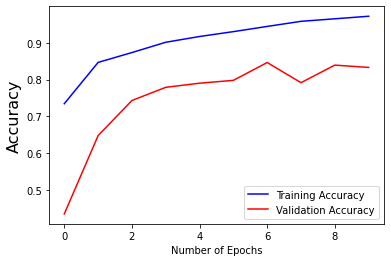

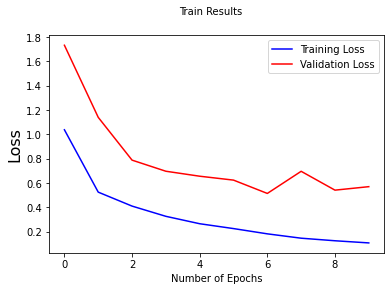

In [101]:
plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(resnet_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(resnet_history.history['loss'], color='b', label='Training Loss')
plt.plot(resnet_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [102]:
resnet_model = load_model('best_model_resnet.h5')

In [104]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
y_pred = resnet_model.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1) 

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))

[[ 27   0   0   0   5   1  43   0   2   0   0   1]
 [  0 109   4   1   0   2   0   1   0   0   0   0]
 [  0   4  74   0   0   1   0   3   4   0   0   0]
 [  0   0   0 168   0   2   1   0   7   3   2   0]
 [  2   0   2   0  48   2   7   2   2   0   0   1]
 [  0   6   8   2   2 111   1   1   4   2   3   3]
 [ 11   0   0   0   5   0 177   0   2   0   0   1]
 [  0   0   0   1   0   0   0  62   1   0   0   2]
 [  1   0   1   2   2   0   1   0 145   1   0   2]
 [  0   2   0   1   0   0   0   0  11  51   0   4]
 [  0   5   0   3   0   2   1   0   0   1 135   2]
 [  1   2   0   1   1   6   0   3   2   0   1  99]]
              precision    recall  f1-score   support

           0       0.64      0.34      0.45        79
           1       0.85      0.93      0.89       117
           2       0.83      0.86      0.85        86
           3       0.94      0.92      0.93       183
           4       0.76      0.73      0.74        66
           5       0.87      0.78      0.82       143
        